<a href="https://colab.research.google.com/github/yongjulee0213/SentenceClassifier/blob/main/my_code%2Bfinal_team_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 필요한 라이브러리 설치/임포트/WANDB 로그인


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
from collections import defaultdict
import random
import gc

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import numpy as np
from tqdm import tqdm

import sentencepiece #transformer의 몇 라이브러리가 sentencepiece 요구함


from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    ElectraForSequenceClassification,
    ElectraTokenizer
)
import pandas as pd
# 📈 For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from torch.utils.data import Dataset, DataLoader

In [5]:
# Log in to your W&B account
wandb.login()


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tarcon3 (goorm). Use `wandb login --relogin` to force relogin


True



## seed 고정/GPU 설정

In [6]:
# random seed
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Tokenizer & model name

In [7]:
#MY_MODEL_NAME = 'bert-base'
#MY_MODEL_NAME = 'bert-large'
MY_MODEL_NAME = 'albert-base'
#MY_MODEL_NAME = 'albert-large'
#MY_MODEL_NAME = 'roberta-base'
#MY_MODEL_NAME = 'roberta-large'
#MY_MODEL_NAME = 'electra-base'

In [8]:
if MY_MODEL_NAME == 'bert-base': tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif MY_MODEL_NAME == 'bert-large': tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
elif MY_MODEL_NAME == 'albert-base': tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
elif MY_MODEL_NAME == 'albert-large': tokenizer = AlbertTokenizer.from_pretrained("albert-large-v2")
elif MY_MODEL_NAME == 'roberta-base': tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
elif MY_MODEL_NAME == 'roberta-large': tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
elif MY_MODEL_NAME == 'electra-base': tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")

In [9]:
print(MY_MODEL_NAME)
print(tokenizer)

albert-base
PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


## dataset

1. data file 업로드

In [10]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev (1).0
Saving sentiment.dev.1 to sentiment.dev (1).1
Saving sentiment.train.0 to sentiment.train (1).0
Saving sentiment.train.1 to sentiment.train (1).1
Saving test_no_label.csv to test_no_label (1).csv


In [11]:
!ls

 model_albert-base_32_adamw_1e-05_0_1_ckp.bin   sentiment.train.1
 sample_data				       'sentiment.train (1).0'
 sentiment.dev.0			       'sentiment.train (1).1'
 sentiment.dev.1			       'test_no_label (1).csv'
'sentiment.dev (1).0'			        test_no_label.csv
'sentiment.dev (1).1'			        wandb
 sentiment.train.0


2. preprocessing ; 데이터 파일 가져와 데이터 구분하기

In [12]:
def file_to_sentence_dataframe(file_name):
  file_data=[]
  with open(file_name,'r',encoding='utf-8') as f: #파일 가져와서
    for sentence in f: #파일을 한줄 씩 읽어서 문장을 가져와
      file_data.append(str(sentence.lower()[:-1].strip()))#모두 소문자로 만들기+공백제거
#review ,label을 가진 dataframe으로 변환
  file_csv=pd.DataFrame({'review':file_data,'label':int(file_name[-1])})
  return file_csv

In [13]:
train_pos=file_to_sentence_dataframe('sentiment.train.1')
train_neg=file_to_sentence_dataframe('sentiment.train.0')
dev_pos=file_to_sentence_dataframe('sentiment.dev.1')
dev_neg=file_to_sentence_dataframe('sentiment.dev.0')

In [14]:
train_pos.head()

,review,label
0,excellent food .,1
1,superb customer service .,1
2,they also have daily specials and ice cream wh...,1
3,it 's a good toasted hoagie .,1
4,the staff is friendly .,1


In [15]:
train_neg.head()

,review,label
0,i was sadly mistaken .,0
1,"so on to the hoagies , the italian is general ...",0
2,minimal meat and a ton of shredded lettuce .,0
3,nothing really special & not worthy of the $ _...,0
4,"second , the steak hoagie , it is atrocious .",0


In [16]:
dev_pos.head()

,review,label
0,these donuts have the perfect texture and taste .,1
1,good food for the price .,1
2,"a little dirty on the inside , but wonderful p...",1
3,i always order it when i go there and it is al...,1
4,the rest of the food there is good also and no...,1


In [17]:
dev_neg.head()

,review,label
0,windows have n't been cleaned in years you can...,0
1,waitresses are slow .,0
2,just a mess avoid at all costs !,0
3,bad !,0
4,now pizza is beyond awful and wings are down t...,0


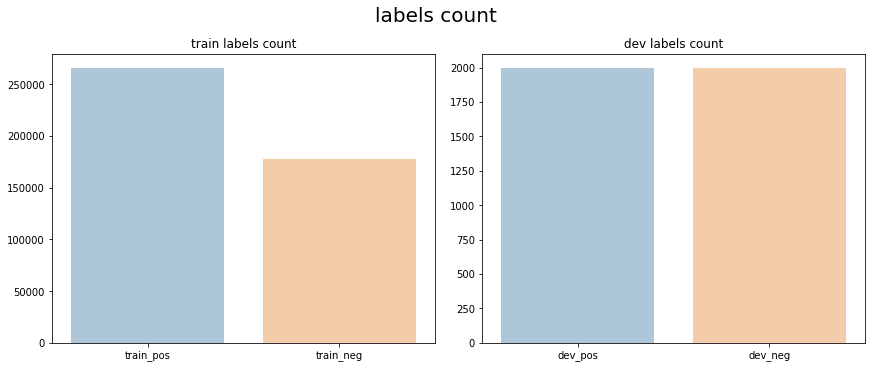

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5), constrained_layout = True)

g1 = sns.barplot(x = np.array(['train_pos', 'train_neg']),
                y = np.array([len(train_pos), len(train_neg)]),
                alpha = .4, ax = ax[0])
g1.set_title("train labels count")

g2 = sns.barplot(x = np.array(['dev_pos', 'dev_neg']),
                y = np.array([len(dev_pos), len(dev_neg)]),
                alpha = .4, ax = ax[1])
g2.set_title("dev labels count")

fig.suptitle('labels count', fontsize=20)
plt.show()

2-2. train, validation용으로 데이터셋 합치기 + 인덱스 reset하여 인덱스가 고유값갖도록 하기

In [19]:
#train, validation용으로 합치고 인덱스 새로 맞춰주기
train_data=pd.concat([train_pos, train_neg])
dev_data=pd.concat([dev_pos, dev_neg])

train_data=train_data.reset_index(drop=True)
dev_data=dev_data.reset_index(drop=True)

In [20]:
train_data

,review,label
0,excellent food .,1
1,superb customer service .,1
2,they also have daily specials and ice cream wh...,1
3,it 's a good toasted hoagie .,1
4,the staff is friendly .,1
...,...,...
443254,this place sucks .,0
443255,does n't stop by to see if you need anything .,0
443256,food is terrible .,0
443257,service horrible .,0


In [21]:
dev_data

,review,label
0,these donuts have the perfect texture and taste .,1
1,good food for the price .,1
2,"a little dirty on the inside , but wonderful p...",1
3,i always order it when i go there and it is al...,1
4,the rest of the food there is good also and no...,1
...,...,...
3995,i am sad to see how much this place has gone d...,0
3996,the food here is n't very good .,0
3997,it has n't been for quite a few years .,0
3998,the service the last time i went was just terr...,0


2-3. tokenizer로 인코딩

In [22]:
#수치화하기
def make_id(tokenizer,data):
  id_file=[]
  for sentence in data['review']:
    id_file.append(tokenizer.encode(sentence))
  return id_file

In [23]:
train_data_id=make_id(tokenizer, train_data)
dev_data_id=make_id(tokenizer, dev_data)

In [24]:
train_data_id[:5]

[[2, 5977, 950, 13, 9, 3],
 [2, 18656, 7705, 365, 13, 9, 3],
 [2, 59, 67, 57, 1954, 621, 18, 17, 1392, 5262, 56, 25, 510, 254, 13, 9, 3],
 [2, 32, 13, 22, 18, 21, 254, 13865, 69, 20538, 7298, 13, 9, 3],
 [2, 14, 1138, 25, 4753, 13, 9, 3]]

In [25]:
dev_data_id[:5]

[[2, 158, 221, 1982, 18, 57, 14, 2107, 12714, 17, 3576, 13, 9, 3],
 [2, 254, 950, 26, 14, 2162, 13, 9, 3],
 [2,
  21,
  265,
  6121,
  27,
  14,
  572,
  13,
  15,
  47,
  5934,
  148,
  30,
  170,
  80,
  13,
  187,
  3],
 [2, 31, 550, 389, 32, 76, 31, 162, 80, 17, 32, 25, 550, 13706, 13, 9, 3],
 [2, 14, 760, 16, 14, 950, 80, 25, 254, 67, 17, 52, 253, 5381, 13, 9, 3]]

3.dataset 재정의/생성

In [26]:
class SentimentDataset(object):
    def __init__(self,dataframe_ids, dataframe):
        self.dataframe=dataframe
        self.dataframe_ids=dataframe_ids

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
				#인코딩된 문장과 레이블 내보내기
        return np.array(self.dataframe_ids[index]),np.array(self.dataframe['label'][index])

In [27]:
#데이터 셋 구성 ; get_item ; 숫자화된 리뷰데이터와 레이블 가져오기
train_dataset = SentimentDataset(train_data_id,train_data)
dev_dataset = SentimentDataset(dev_data_id,dev_data)

4. dataloader 만들기

In [28]:
def collate_fn_style(samples):#가변길이 배치를 패딩하는데 사용?samples ; train_dataset/dev_dataset
    input_ids_, labels = zip(*samples)#input_ids 수치화된 리뷰데이터, labels ; 긍부정

    max_len = max(len(input_id) for input_id in input_ids_)#42 : 가장 문장의 길이가 긴 것을 찾자
    
    #[::-1] ; 문자열 거꾸로 출력하기
    #문장길이를 작은것->큰것으로 정렬한 인덱스를 취해서 반대로 정렬 -> 왼쪽이 길이가 긴것. 오른쪽으로 갈수록 길이가 짧아짐
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids_])[::-1]

    #pad_sequence : 일정한 길이로 맞춰줄 때 사용. 빈공간은 0 으로 채워짐.
    '''
    pad_sequence(sequences, batch_first,padding_value)
    sequence ; 가변길이 시퀀스 리스트 ; 길이가 다양한 문장 시퀀스
    batch_first ;  B x T x * if True, or in T x B x * otherwise
    '''
    input_ids = pad_sequence([torch.tensor(input_ids_[index]) for index in sorted_indices],
                             batch_first=True)
    
    #attention 연산이 수행되어야할 토큰과 그렇지 않은 토큰 구분
    #인덱스에 해당하는 패딩된 수치로 표현된 문장의 전체길이의 크기만큼 1로 채운다 =연산수행
    #padding으로 채워진 부분은 attention 연산이 수행될 필요가 없으므로 0 부여.
    attention_mask = torch.tensor(
        [[1] * len(input_ids_[index]) + [0] * (max_len - len(input_ids_[index])) for index in
         sorted_indices])
    
    #각 토큰이 어떤 문장에 속하는지 나타냄 : 첫번째 문장이 0, 두번째 문장이 1
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [29]:
train_batch_size=32
eval_batch_size=64
#collate_fn : dataset이 고정길이가 아닌 경우, 배치를 2 이상으로 dataloader를 호출하면
#dataloader에서 batch로 바로 못묶이고 에러가남.-> 함수를 직접 작성해서 넘겨줘야함.
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=False, collate_fn=collate_fn_style,
                                         num_workers=2)

5. Small sample of dataset

- 데이터셋 일부만 사용하고 싶다면

In [30]:
#SMALL_SAMPLE, PERC = True, 0.01 # 데이터셋 일부만 사용하고 싶다면
SMALL_SAMPLE = False # 전체 데이터셋을 사용하고 싶다면면

In [31]:
if SMALL_SAMPLE == True:
    train_dataset_total = SentimentDataset(tokenizer, train_pos, train_neg)
    dev_dataset_total = SentimentDataset(tokenizer, dev_pos, dev_neg)

    train_dataset = random.sample(list(train_dataset_total), int(PERC * len(train_dataset_total)))
    dev_dataset = random.sample(list(dev_dataset_total), int(PERC * len(dev_dataset_total)))

    print(len(train_dataset_total))
    print(len(dev_dataset_total))
    print(len(train_dataset))
    print(len(dev_dataset))

    del train_dataset_total
    del dev_dataset_total
    gc.collect()

## Model

In [32]:
if MY_MODEL_NAME == 'bert-base': model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
elif MY_MODEL_NAME == 'bert-large': model = BertForSequenceClassification.from_pretrained('bert-large-uncased')
elif MY_MODEL_NAME == 'albert-base': model = AlbertForSequenceClassification.from_pretrained("albert-base-v2")
elif MY_MODEL_NAME == 'albert-large': model = AlbertForSequenceClassification.from_pretrained("albert-large-v2")
model.to(device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

## Hyperparameter Tuning

In [33]:
def build_optimizer(model, optimizer, learning_rate, weight_decay):
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adamw':
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    return optimizer

### ✅ Define sweep config

- sweep_configuration
```
CASE = 'Case3'
```
- [`method`](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#method)
```
'method': 'grid',
```
    - grid: Grid search iterates over all possible combinations of parameter values.
    - random: Random search chooses a random set of values on each iteration.
    - bayes: Our Bayesian hyperparameter search method uses a Gaussian Process to model the relationship between the parameters and the model metric and chooses parameters to optimize the probability of improvement. This strategy requires the metric key to be specified.

In [34]:
CASE = 'Case3' # 'Case1', 'Case2', 'Case3' 중 하나만

In [35]:
# 🐝 Step 1: Define sweep config
if CASE == 'Case1':
    MY_PARAMETERS = {
        'batch_size': {'values': [32]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [1e-01, 1e-02, 1e-03, 1e-04, 1e-05]},
        'weight_decay': {'values': [0]},
        'epochs': {'values': [1]}
    }
elif CASE == 'Case2':
    MY_PARAMETERS = {
        'batch_size': {'values': [32,64,128]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [ 1e-04, 1e-05]}, # {'max': 0.1, 'min': 0.0001}
        'weight_decay': {'values': [1e-04,1e-05,0]}, # {'max': 0.1, 'min': 0.0}
        'epochs': {'values': [1]} # {'values': [1]}
    }
elif CASE == 'Case3':
    MY_PARAMETERS = {
        'batch_size': {'values': [32,64]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [1e-05]}, # {'max': 0.1, 'min': 0.0001}
        'weight_decay': {'values': [0,0.0001]}, # {'max': 0.1, 'min': 0.0}
        'epochs': {'values': [1,3,5,10]} # {'values': [1]}
    }

sweep_configuration = {
    'method': 'grid', # 'random'
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': "val/val_accuracy"},
    'description': MY_MODEL_NAME,
    'parameters': MY_PARAMETERS
}

# 🐝 Step 2: Initialize sweep by passing in config
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'albert-base{CASE}')

Create sweep with ID: u9osbunp
Sweep URL: https://wandb.ai/goorm/albert-baseCase3/sweeps/u9osbunp


## Training

In [36]:
# Choose whether to draw loss graph using Matplotlip
DRAW_GRAPH = True # 그래프를 그리고 싶다면
#DRAW_GRAPH = False # 그래프를 그리고 싶지 않다면

# Determine how many times to validate per epoch
VALID_INTERVAL = 5 # 5 (권장)

# Determine minimum validation accuracy
LOWEST_VAL_ACC = 0.9

In [37]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [45]:
# 🐝 Step 3: Define training function that takes in hyperparameter 
# values from `wandb.config` and uses them to train a model and return metric
def main():
    # 🐝 initialise a wandb run
    # Use the wandb.init() API to generate a background process 
    # to sync and log data as a Weights and Biases run.
    # Optionally provide the name of the project.
    # 🐝 initialise a wandb run
    run = wandb.init(project=f'albert-base{CASE}')

    # note that we define values from `wandb.config` instead of 
    # defining hard values
    batch_size = wandb.config.batch_size
    optim = wandb.config.optimizer
    lr  =  wandb.config.lr
    weight_decay = wandb.config.weight_decay
    epochs = wandb.config.epochs

    my_name = "model_" + MY_MODEL_NAME + "_" + str(batch_size) + "_" + str(optim) + "_" + str(lr) + "_" + str(weight_decay) + "_" + str(epochs)
    run.name = my_name
    
    # Make the loss and optimizer
    optimizer = build_optimizer(model, optim, lr, weight_decay)

     # 📈 For visualization using Matplotlib
    train_loss_history = []
    valid_loss_history = []

    # Training
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
                model.train()
                tepoch.set_description(f"Epoch {epoch}")
                
                # Train
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                position_ids = position_ids.to(device)
                labels = labels.to(device, dtype=torch.long)

                optimizer.zero_grad()
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    position_ids=position_ids,
                    labels=labels)
                train_loss = outputs.loss
                train_loss.backward()
                optimizer.step()
                
                # 🐝 Log train metrics to wandb 
                wandb.log({
                    "train/epoch": epoch,
                    "train/train_loss": train_loss
                })

                tepoch.set_postfix(loss=train_loss.item())

                if iteration != 0 and iteration % int(len(train_loader) / VALID_INTERVAL) == 0:
                    # Evaluate the model [VALID_INTERVAL] times per epoch
                    model.eval()
                    with torch.no_grad():
                        val_losses = []
                        predictions = []
                        target_labels = []
                        for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(
                            dev_loader,
                            desc='Eval',
                            position=1,
                            leave=None):
                            # Validation
                            input_ids = input_ids.to(device)
                            attention_mask = attention_mask.to(device)
                            token_type_ids = token_type_ids.to(device)
                            position_ids = position_ids.to(device)
                            labels = labels.to(device, dtype=torch.long)

                            outputs = model(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                labels=labels)
                            loss = outputs.loss
                            logits = outputs.logits
                            val_losses.append(loss.item())

                            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                            batch_labels = [int(example) for example in labels]

                            predictions += batch_predictions
                            target_labels += batch_labels
                    
                    val_loss = sum(val_losses) / len(val_losses)
                    val_acc = compute_acc(predictions, target_labels)

                    # 🐝 Log validation metrics to wandb
                    wandb.log({
                        "val/val_accuracy": val_acc,
                        "val/val_loss": val_loss
                    })
                    train_loss_history.append(train_loss)  # 📈 For visualization using Matplotlib
                    valid_loss_history.append(val_loss)  # 📈 For visualization using Matplotlib
                    print('=====> val_acc: ', val_acc)
                    
                    # 💾 [LOWEST_VAL_ACC]보다 크면 parameters 저장
                    if val_acc > LOWEST_VAL_ACC:
                        torch.save(model.state_dict(), my_name + '_ckp.bin') # checkpoint
                        print('\nSaved the model!')

    # 💾 학습이 완료되면 최종 parameters를 저장
    torch.save(model.state_dict(), my_name + '.bin')

    if DRAW_GRAPH:
        # 📈 For visualization using Matplotlib
        # 간단하게 train loss & validation loss 시각화
        train_loss_history = torch.tensor(train_loss_history).detach().cpu().numpy()
        valid_loss_history = torch.tensor(valid_loss_history).detach().cpu().numpy()
        plt.plot(train_loss_history, label = "Train Loss")
        plt.plot(valid_loss_history, label = "Validation Loss")
        plt.title('Loss (' + my_name + ')')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(my_name + '.png') # 💾
        plt.close()

In [46]:
# 🐝 Step 4: Call to `wandb.agent` to start a sweep
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: qp2cxhgq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 0:  20%|██        | 2772/13852 [02:14<48:58,  3.77batch/s, loss=0.0765]

=====> val_acc:  0.97575

Saved the model!


Epoch 0:  40%|████      | 5541/13852 [04:28<41:37,  3.33batch/s, loss=0.0281]

=====> val_acc:  0.9765

Saved the model!


Epoch 0:  60%|█████▉    | 8310/13852 [06:42<04:24, 20.96batch/s, loss=0.0165]

=====> val_acc:  0.978

Saved the model!


Epoch 0:  80%|████████  | 11082/13852 [08:56<12:19,  3.75batch/s, loss=0.0136]

=====> val_acc:  0.97925

Saved the model!


Epoch 0: 100%|█████████▉| 13851/13852 [11:10<00:00,  3.71batch/s, loss=0.451] 

=====> val_acc:  0.97925

Saved the model!


Epoch 1:  20%|██        | 2771/13852 [02:14<49:27,  3.73batch/s, loss=0.0971]

=====> val_acc:  0.9785

Saved the model!


Epoch 1:  40%|████      | 5543/13852 [04:29<36:50,  3.76batch/s, loss=0.0151]

=====> val_acc:  0.976

Saved the model!


Epoch 1:  60%|█████▉    | 8310/13852 [06:43<04:22, 21.10batch/s, loss=0.128]

=====> val_acc:  0.97725

Saved the model!


Epoch 1:  80%|███████▉  | 11081/13852 [08:57<12:18,  3.75batch/s, loss=0.126]

=====> val_acc:  0.98325

Saved the model!


Epoch 1: 100%|██████████| 13852/13852 [11:11<00:00,  3.26batch/s, loss=0.0154]

=====> val_acc:  0.98125

Saved the model!


Epoch 2:  20%|██        | 2772/13852 [02:14<49:28,  3.73batch/s, loss=0.0108]

=====> val_acc:  0.98125

Saved the model!


Epoch 2:  40%|████      | 5541/13852 [04:29<37:05,  3.73batch/s, loss=0.03]

=====> val_acc:  0.98125

Saved the model!


Epoch 2:  60%|██████    | 8312/13852 [06:43<24:30,  3.77batch/s, loss=0.00893]

=====> val_acc:  0.98075

Saved the model!


Epoch 2:  80%|███████▉  | 11080/13852 [08:57<02:16, 20.32batch/s, loss=0.0612]

=====> val_acc:  0.979

Saved the model!


Epoch 2: 100%|█████████▉| 13851/13852 [11:11<00:00,  3.29batch/s, loss=0.00393]

=====> val_acc:  0.98

Saved the model!


Epoch 2: 100%|██████████| 13852/13852 [11:12<00:00, 20.61batch/s, loss=0.00393]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▅▅▂▆▂▂▂▂▂▁▁▂▄▁▄▁▁▁▁▁▃▃▄▅▁▂▁▂▅▂▁▁▁▁▄█▃▁▁▁
val/val_accuracy,▁▂▃▄▄▄▁▂█▆▆▆▆▄▅
val/val_loss,█▅▅▅▃▃▇▄▁▃▁▃▁▄▂
train/epoch,2
train/train_loss,0.00393
val/val_accuracy,0.98
val/val_loss,0.05393


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2tbfevmd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 0:  20%|██        | 2773/13852 [02:15<48:57,  3.77batch/s, loss=0.0914]

=====> val_acc:  0.9815

Saved the model!


Epoch 0:  40%|████      | 5542/13852 [04:29<36:44,  3.77batch/s, loss=0.0229] 

=====> val_acc:  0.98175

Saved the model!


Epoch 0:  60%|█████▉    | 8311/13852 [06:44<24:31,  3.77batch/s, loss=0.0131]

=====> val_acc:  0.9825

Saved the model!


Epoch 0:  80%|████████  | 11082/13852 [08:59<12:23,  3.73batch/s, loss=0.0336]

=====> val_acc:  0.98175

Saved the model!


Epoch 0: 100%|█████████▉| 13851/13852 [11:14<00:00,  3.72batch/s, loss=0.0355] 

=====> val_acc:  0.98225

Saved the model!


Epoch 1:  20%|██        | 2771/13852 [02:15<49:32,  3.73batch/s, loss=0.0111]

=====> val_acc:  0.981

Saved the model!


Epoch 1:  40%|████      | 5542/13852 [04:30<37:06,  3.73batch/s, loss=0.00513]

=====> val_acc:  0.981

Saved the model!


Epoch 1:  60%|█████▉    | 8311/13852 [06:45<24:50,  3.72batch/s, loss=0.00118]

=====> val_acc:  0.981

Saved the model!


Epoch 1:  80%|████████  | 11082/13852 [08:59<12:19,  3.74batch/s, loss=0.000617]

=====> val_acc:  0.981

Saved the model!


Epoch 1: 100%|██████████| 13852/13852 [11:14<00:00,  3.40batch/s, loss=0.0592]

=====> val_acc:  0.98075

Saved the model!


Epoch 2:  20%|██        | 2771/13852 [02:15<49:37,  3.72batch/s, loss=0.00497]

=====> val_acc:  0.97825

Saved the model!


Epoch 2:  40%|████      | 5542/13852 [04:30<36:54,  3.75batch/s, loss=0.00217]

=====> val_acc:  0.98175

Saved the model!


Epoch 2:  60%|█████▉    | 8310/13852 [06:45<04:29, 20.60batch/s, loss=0.197]

=====> val_acc:  0.979

Saved the model!


Epoch 2:  80%|███████▉  | 11080/13852 [09:00<02:11, 21.03batch/s, loss=0.0239]

=====> val_acc:  0.9795

Saved the model!


Epoch 2: 100%|██████████| 13852/13852 [11:14<00:00,  3.40batch/s, loss=0.00052]

=====> val_acc:  0.98125

Saved the model!


Epoch 2: 100%|██████████| 13852/13852 [11:14<00:00, 20.53batch/s, loss=0.00052]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁▁▁▁▂▁█▁▁▂▁▂▁▂▁▂▁▁▂▁▁▁▁▁▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▆▇█▇█▆▆▆▆▅▁▇▂▃▆
val/val_loss,▁▃▂▁▂▅▂▄▅▄▅▅█▆▅
train/epoch,2
train/train_loss,0.00052
val/val_accuracy,0.98125
val/val_loss,0.06852


wandb: Agent Starting Run: et130uau with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 0:  20%|██        | 2773/13852 [02:15<49:31,  3.73batch/s, loss=0.00646]

=====> val_acc:  0.98025

Saved the model!


Epoch 0:  40%|████      | 5541/13852 [04:30<37:13,  3.72batch/s, loss=0.00015]

=====> val_acc:  0.98075

Saved the model!


Epoch 0:  60%|█████▉    | 8310/13852 [06:45<04:26, 20.80batch/s, loss=0.0016]

=====> val_acc:  0.98

Saved the model!


Epoch 0:  80%|███████▉  | 11081/13852 [09:01<12:22,  3.73batch/s, loss=0.000149]

=====> val_acc:  0.9785

Saved the model!


Epoch 0: 100%|█████████▉| 13851/13852 [11:16<00:00,  3.36batch/s, loss=0.000199]

=====> val_acc:  0.977

Saved the model!


Epoch 1:  20%|██        | 2771/13852 [02:15<49:35,  3.72batch/s, loss=0.00108]

=====> val_acc:  0.9775

Saved the model!


Epoch 1:  40%|███▉      | 5540/13852 [04:31<06:38, 20.86batch/s, loss=0.0117]

=====> val_acc:  0.97825

Saved the model!


Epoch 1:  60%|█████▉    | 8311/13852 [06:45<24:46,  3.73batch/s, loss=0.0685]

=====> val_acc:  0.98125

Saved the model!


Epoch 1:  80%|███████▉  | 11080/13852 [09:00<02:11, 21.10batch/s, loss=0.0027]

=====> val_acc:  0.97975

Saved the model!


Epoch 1: 100%|█████████▉| 13851/13852 [11:15<00:00,  3.36batch/s, loss=0.00379]

=====> val_acc:  0.98325

Saved the model!


Epoch 2:  20%|██        | 2771/13852 [02:15<49:30,  3.73batch/s, loss=0.000909]

=====> val_acc:  0.98

Saved the model!


Epoch 2:  40%|███▉      | 5540/13852 [04:30<06:36, 20.94batch/s, loss=0.00075]

=====> val_acc:  0.98

Saved the model!


Epoch 2:  60%|█████▉    | 8310/13852 [06:45<04:21, 21.21batch/s, loss=0.00349]

=====> val_acc:  0.98175

Saved the model!


Epoch 2:  68%|██████▊   | 9486/13852 [07:41<03:31, 20.68batch/s, loss=0.00294]wandb: Ctrl + C detected. Stopping sweep.


In [47]:
# 🐝 Close your wandb run
wandb.finish()

Epoch 2:  68%|██████▊   | 9488/13852 [07:42<03:32, 20.54batch/s, loss=0.00294]
Exception in thread Thread-45:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "<ipython-input-45-524a7087d8c4>", line 55, in main
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_run.py", line 292, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_run.py", line 255, in wrapper
    return func(self, *args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_run.py", line 1612, in log
    self._log(data=data, step=step, commit=commit)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_run.py", line 1394, in _log
    self._partial_history_callback(data, step, commit)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_run.py", line 1278, in _partial_history_callback
    self._backend

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
train/train_loss,▁▁▁▂▃▁▁▁▄▁▂▃▁▁▂▁▁▁▂▁▁▁▁▁▁█▅▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▅▅▄▃▁▂▂▆▄█▄▄▆
val/val_loss,▂▂▄▄▄▇▄▃▄▁▇█▄
train/epoch,2
train/train_loss,0.00136
val/val_accuracy,0.98175
val/val_loss,0.07931


## Visualization using Matplotlib

- 출처: https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

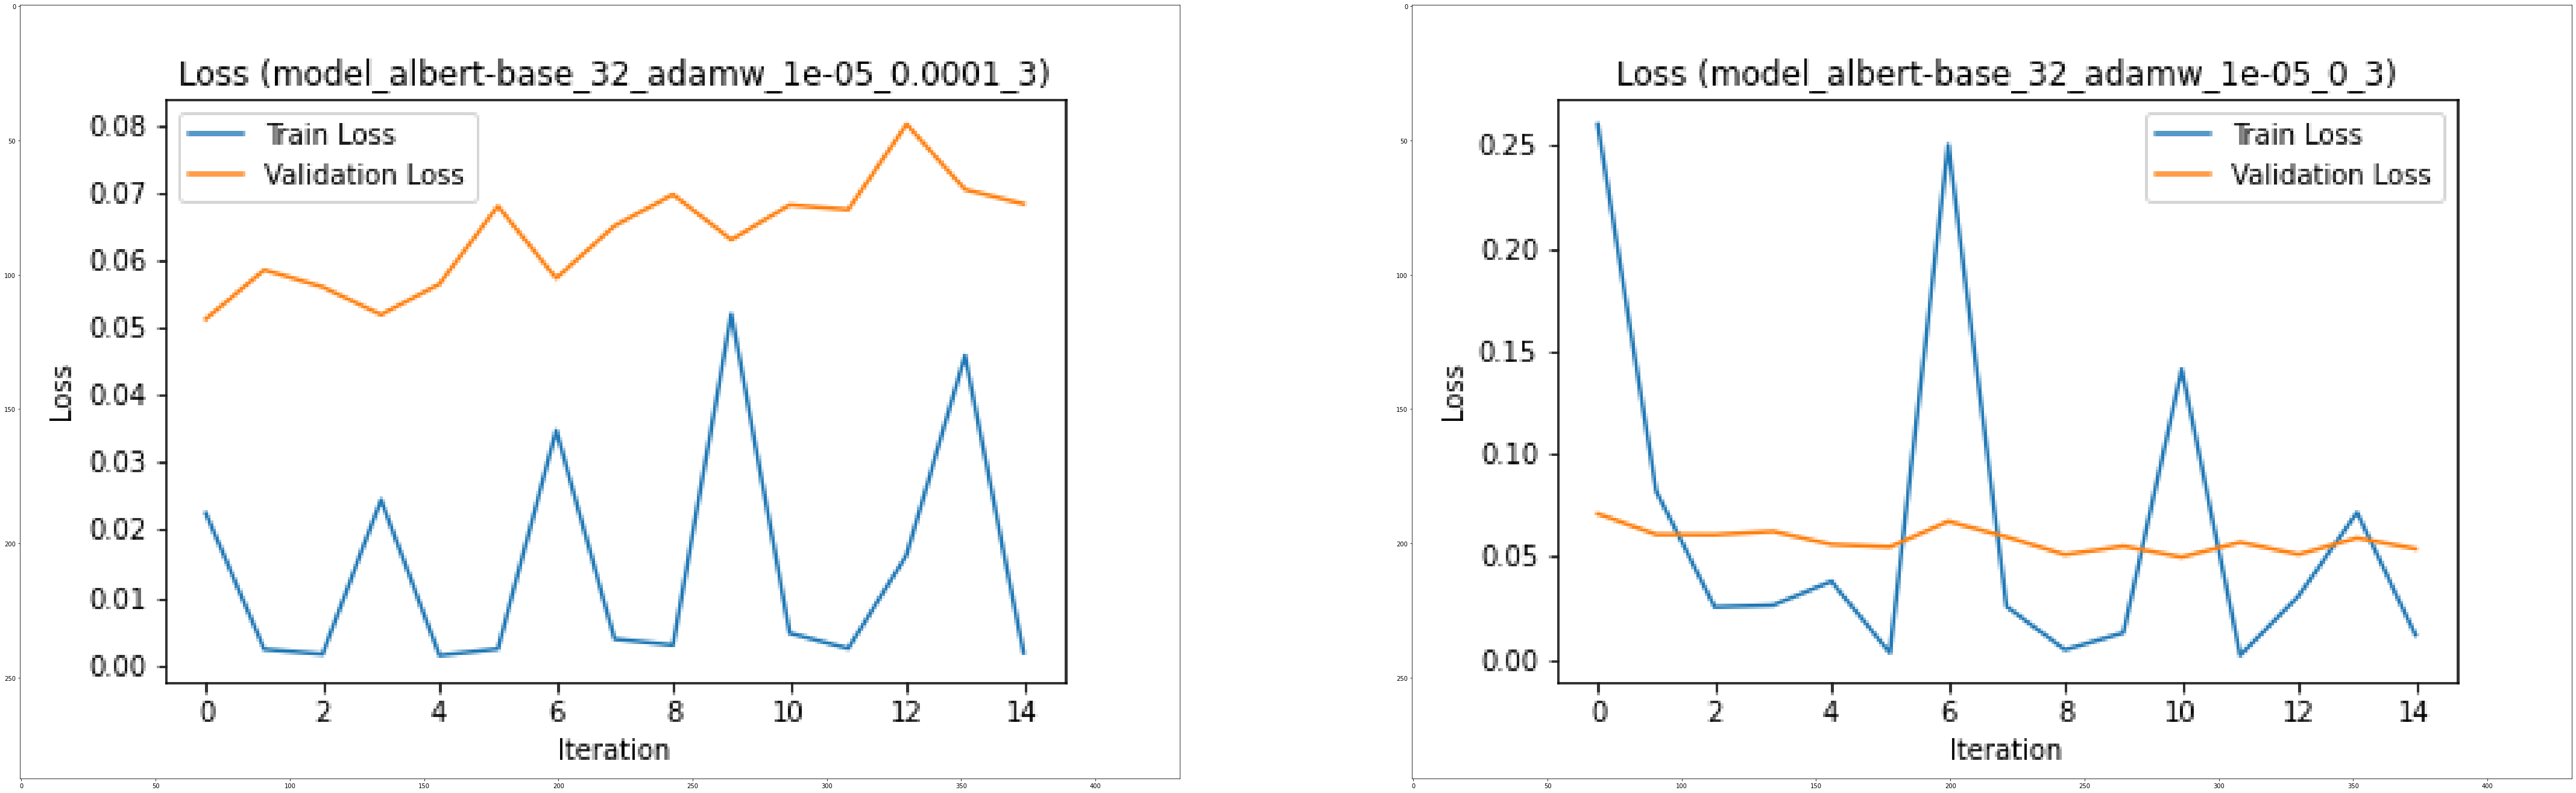

In [48]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(200, 100))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## Submit Test file

1. 가장 학습이 잘 된 파라미터 가져와서 모델에 넣기

In [49]:
model =AlbertForSequenceClassification.from_pretrained("albert-base-v2")
model.to(device)
model.load_state_dict(torch.load('/content/model_albert-base_32_adamw_1e-05_0_5.bin'))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

FileNotFoundError: ignored

2. 테스트 파일 만들기

In [ ]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [ ]:
test_dataset = test_df['Id']

In [ ]:
#수치화하기
def make_id(tokenizer,data):
  id_file=[]
  for sentence in data:#train/dev data와 달리 column이름 필요없음
    id_file.append(tokenizer.encode(sentence))
  return id_file
test_id=make_id(tokenizer,test_data) #문장->수치

In [ ]:
class SentimentTestDataset(object):
    def __init__(self,dataframe_ids):
        self.dataframe_ids=dataframe_ids

    def __len__(self):
        return len(self.dataframe_ids)

    def __getitem__(self, index):
        return np.array(self.dataframe_ids[index])#training/dev와 달리 label이 없음

test_dataset=SentimentTestDataset(test_id) #데이터셋 생성

In [ ]:
def collate_fn_style_test(samples):
    input_ids_ = samples
    max_len = max(len(input_id) for input_id in input_ids_)
    sorted_indices = range(len(input_ids_))

    input_ids = pad_sequence([torch.tensor(input_ids_[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask= torch.tensor(
        [[1] * len(input_ids_[index]) + [0] * (max_len - len(input_ids_[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
#데이터 로더 생성
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

3. forward prop

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(
        test_loader,
        desc='Test',
        position=1,
        leave=None):
        # Test
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids)

        logits = outputs.logits
        
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission_albert_base_best.csv', index=False)

In [ ]:
test_df